

# MSAAI-501 Intro to Artificial Intelligence
# Group 3 Final Project - Using Computer Vision to Predict Ocular Disease

Team Members:
  Elan Wilkinson,
  Ben Hopwood,
  Sarah Durrani


### Data Source and Description:

Date Source:
Maranhão, A. (2020, September 24). Ocular Disease Recognition: Right and left eye fundus photographs of 5000 patients. Kaggle. https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k  

Project Desciption: This project explored taking a fundal image to classify it as appearing healthy or indicative of:
  - diabetes
  - glaucoma
  - cataracts
  - age-related macular degeneration
  - hypertension
  - pathological myopia
  - or other diseases/concerns.
  
This team explored multiple approaches to determine which solution provides the best classification results. These include Convoluted Neural Networks (CNN), Residual Neural Networks (RNN), Support Vector Machines, YOLO, and ResNet. The project estimated the category of disease a fundal image would fall into and give a measure of the agent’s confidence in the classification. While accuracy and precision are paramount metrics to base performance on, the speed/memory required to perform the calculations was also considered.

### **Import Necessary Libraries:**

In [209]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import random
import os
import shutil
import zipfile
import io

from tqdm import tqdm
from PIL import Image
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.vgg16 import preprocess_input

## Exploratory Data Analysis

### Initial Read in of Data

In [109]:
ocular_disease_filepath = "C:/Users/elanw/OneDrive/Documents/IntroToAI/Final_Project/CV-Prediction-of-Ocular-Disease/data_processed.xlsx"

ocular_disease_df = pd.read_excel(ocular_disease_filepath)

### Diagnoses of Ocular Disease Present in Dataset

The initial dataset initially had one-hot encoded columns for each of 8 eight eye conditions:
- N - Normal
- D - Diabetes
- G - Glaucoma
- C - Cataract
- A - Age Related Macular Degeneration
- H - Hypertension
- M - Pathological Myopia
- O - Other

### Correction of one-hot encoded labels to per-eye labeling

However, these were one-hot encoded as a diagnosis for the patient, not per eye. May of the diagnoses present were only applicable to one eye but not the other, causing incorrect labeling of image data. Manual modification of the excel file containing patient ocular data was performed in an external program to create one-hot encoded columns per eye.

In [110]:
ocular_disease_df.drop(['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O'], axis=1, inplace=True)

### View of the Dataframe

In [111]:
ocular_disease_df.head(10)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,Left-N,Right-N,Left-D,...,Left-C,Right-C,Left-A,Right-A,Left-H,Right-H,Left-M,Right-M,Left-O,Right-O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,6,60,Male,6_left.jpg,6_right.jpg,macular epiretinal membrane,moderate non proliferative retinopathy，epireti...,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,7,60,Female,7_left.jpg,7_right.jpg,drusen,mild nonproliferative retinopathy,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus,1,1,0,...,0,0,0,0,0,0,0,0,0,0
9,9,54,Male,9_left.jpg,9_right.jpg,normal fundus,vitreous degeneration,1,0,0,...,0,0,0,0,0,0,0,0,0,1


### Summary Statistics

In [112]:
print("\nSummary Statistics:")
print(ocular_disease_df.describe())


Summary Statistics:
                ID  Patient Age       Left-N      Right-N       Left-D  \
count  3500.000000  3500.000000  3500.000000  3500.000000  3500.000000   
mean   2218.233143    57.854000     0.451429     0.435429     0.274000   
std    1415.437872    11.724064     0.497706     0.495884     0.446073   
min       0.000000     1.000000     0.000000     0.000000     0.000000   
25%     876.750000    51.000000     0.000000     0.000000     0.000000   
50%    2372.500000    59.000000     0.000000     0.000000     0.000000   
75%    3247.250000    66.000000     1.000000     1.000000     1.000000   
max    4784.000000    91.000000     1.000000     1.000000     1.000000   

           Right-D       Left-G      Right-G       Left-C      Right-C  \
count  3500.000000  3500.000000  3500.000000  3500.000000  3500.000000   
mean      0.283429     0.050571     0.042571     0.045429     0.044000   
std       0.450727     0.219152     0.201918     0.208272     0.205124   
min       0.0000

### Data Visualization

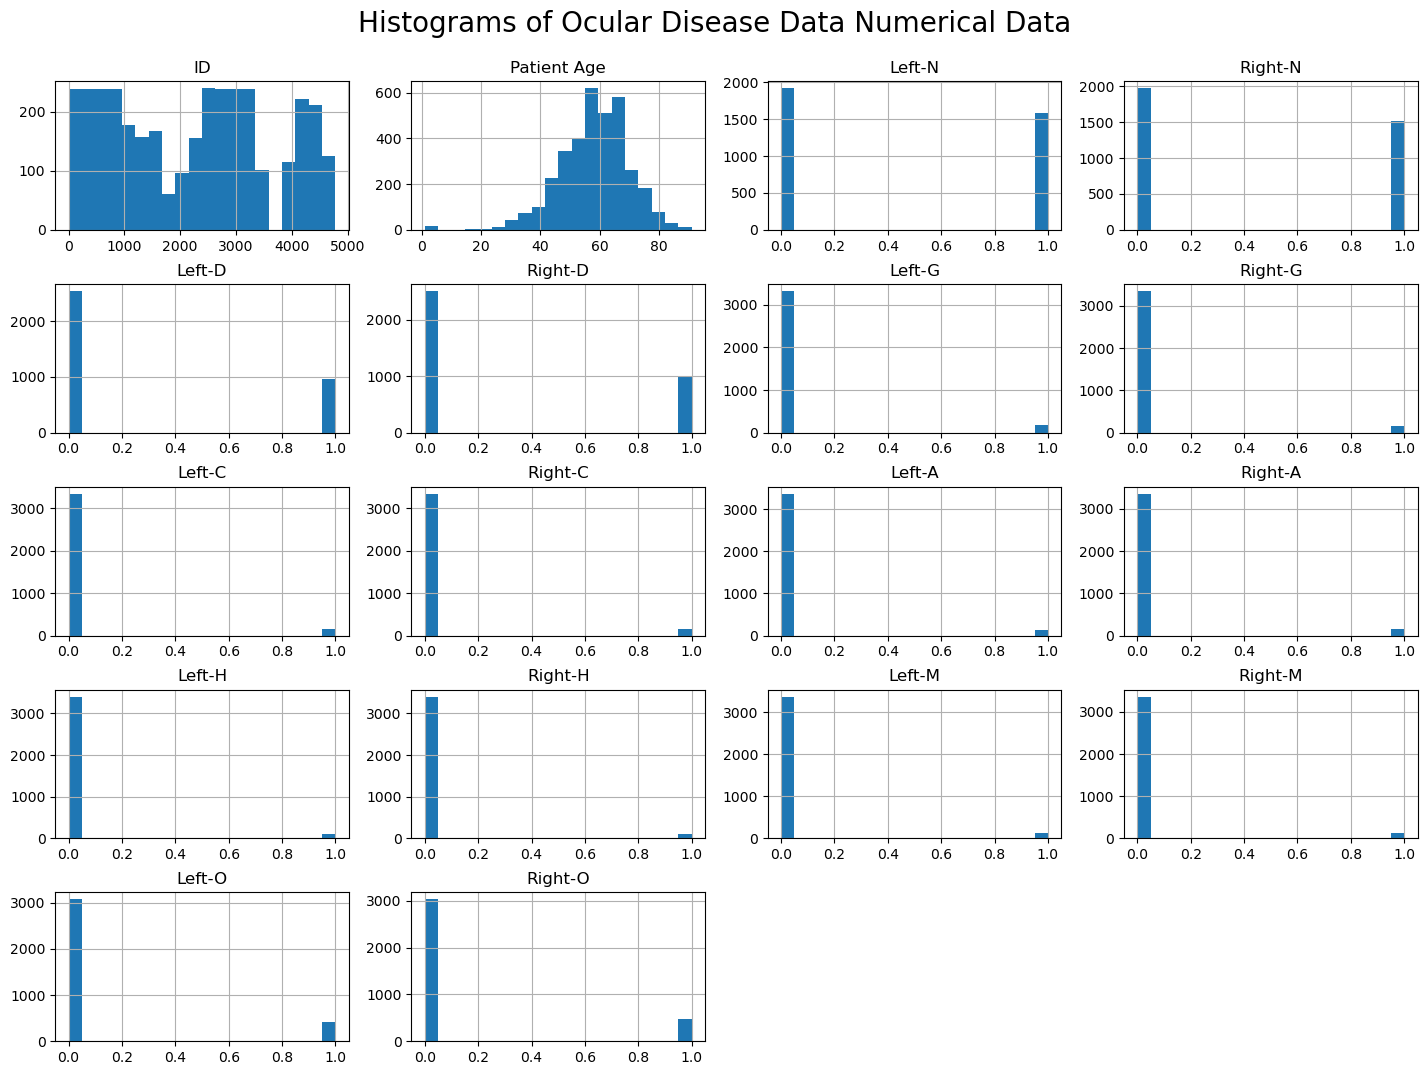

In [136]:
ocular_disease_df.hist(figsize=(12, 10), bins=20)
plt.suptitle("Histograms of Ocular Disease Data Numerical Data\n", fontsize=20, y=1.07, x =.6)
plt.tight_layout(rect=(0, 0, 1.2, 1.2))
plt.subplots_adjust(top=0.999)
plt.show()

### Patient Ages

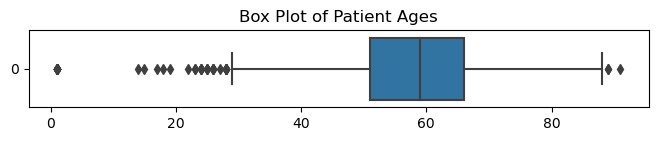

In [144]:
# 2.2 Box Plots
plt.figure(figsize=(8, 1))
sns.boxplot(ocular_disease_df['Patient Age'], orient="h")
plt.title("Box Plot of Patient Ages")
plt.show()

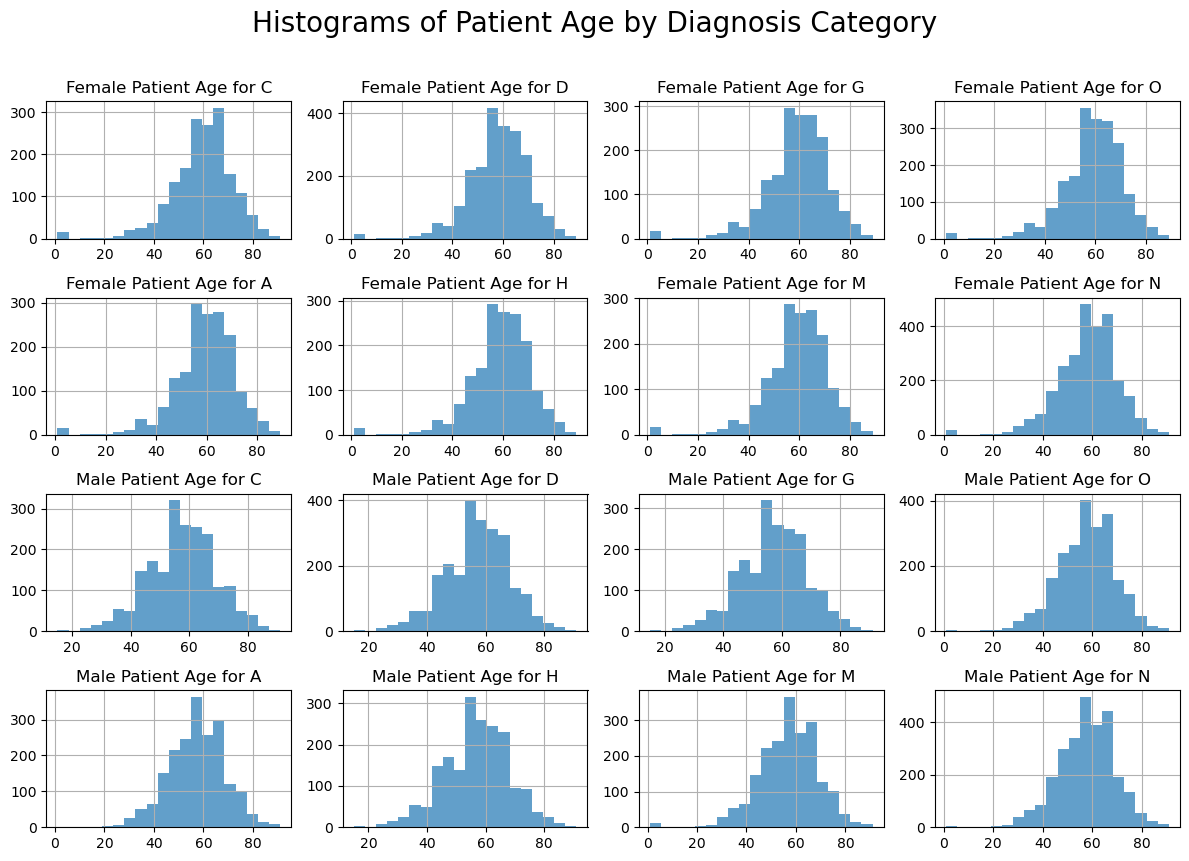

In [187]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 8))
axes = axes.flatten()


idx = 0
sides = ['Left', 'Right']
categs = ['C', 'D', 'G', 'O', 'A', 'H', 'M', 'N']

def plot_by_agesexcat(sex):
    global idx
    for cat in categs:
        df_by_cat = ocular_disease_df[(ocular_disease_df[f"Left-{cat}"] == 1) | (ocular_disease_df[f"Right-{cat}"] == 1) | (ocular_disease_df['Patient Sex'] == sex)]
        axes[idx].hist(df_by_cat[f'Patient Age'], bins=20, alpha=0.7)
        axes[idx].set_title(f'{sex} Patient Age for {cat}')
        axes[idx].grid(True)
        idx += 1

plot_by_agesexcat('Female')
plot_by_agesexcat('Male')

plt.tight_layout()
plt.suptitle("Histograms of Patient Age by Diagnosis Category\n", fontsize=20, y=1.07, x =.5)
plt.show()



### Missing Values Check

There were no missing values in any of the columns in the dataframe.

In [176]:
missing_percentage = ocular_disease_df.isnull().mean() * 100
print("\nPercentage of Missing Values in Each Column:")
print(missing_percentage)


Percentage of Missing Values in Each Column:
ID                           0.0
Patient Age                  0.0
Patient Sex                  0.0
Left-Fundus                  0.0
Right-Fundus                 0.0
Left-Diagnostic Keywords     0.0
Right-Diagnostic Keywords    0.0
Left-N                       0.0
Right-N                      0.0
Left-D                       0.0
Right-D                      0.0
Left-G                       0.0
Right-G                      0.0
Left-C                       0.0
Right-C                      0.0
Left-A                       0.0
Right-A                      0.0
Left-H                       0.0
Right-H                      0.0
Left-M                       0.0
Right-M                      0.0
Left-O                       0.0
Right-O                      0.0
dtype: float64


### Correlation Analysis

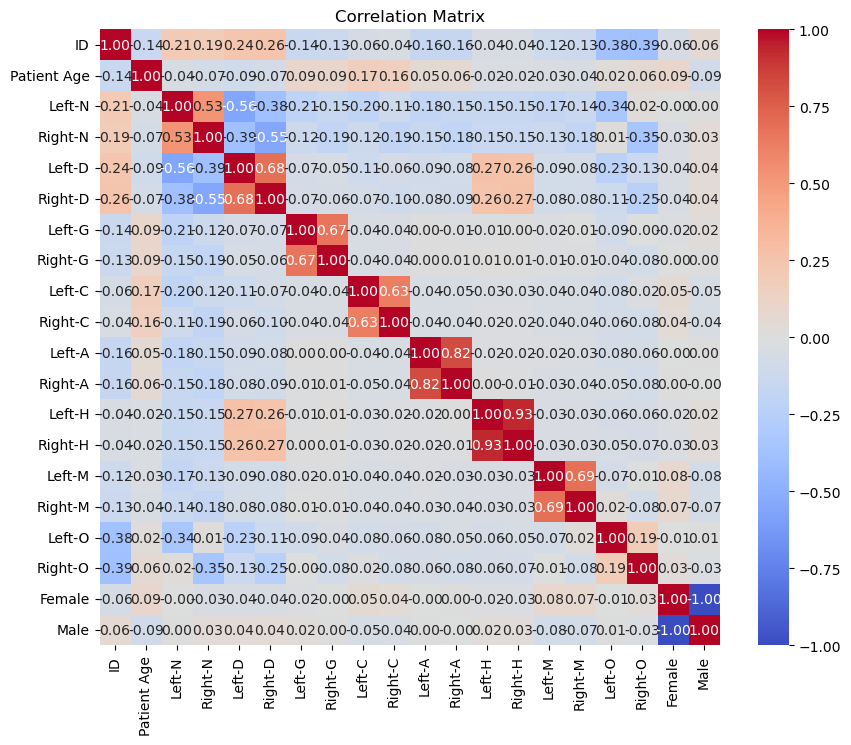

In [202]:
one_hot_psex = pd.get_dummies(ocular_disease_df['Patient Sex'])

one_hot_psex = ocular_disease_df.join(one_hot_psex)
one_hot_psex.drop(['Patient Sex','Left-Fundus','Right-Fundus','Left-Diagnostic Keywords','Right-Diagnostic Keywords'], axis =1, inplace=True)

correlation_matrix = one_hot_psex.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### Number of Examples by Category

Text(0, 0.5, 'Number of Patients')

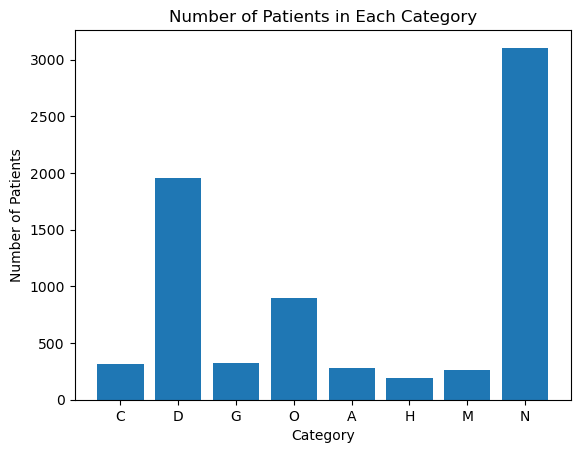

In [207]:
cat_counts = []

for cat in categs:
    cat_counts.append((ocular_disease_df[f'Left-{cat}'].sum() + ocular_disease_df[f'Right-{cat}'].sum()))

plt.bar(x=categs, height=cat_counts)
plt.title("Number of Patients in Each Category")
plt.xlabel("Category")
plt.ylabel("Number of Patients")

In [66]:
# These are the paths to the dataset folders on my local machine.
train_base_dir = 'C:/Users/elanw/OneDrive/Documents/IntroToAI/Final_Project/CV-Prediction-of-Ocular-Disease/ocular-disease-recognition-odir5k/train/'
image_dir = 'C:/Users/elanw/OneDrive/Documents/IntroToAI/Final_Project/CV-Prediction-of-Ocular-Disease/ocular-disease-recognition-odir5k/preprocessed_images/'

In [67]:
Main_df.head(10)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,Left-N,Right-N,Left-D,...,Left-C,Right-C,Left-A,Right-A,Left-H,Right-H,Left-M,Right-M,Left-O,Right-O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,6,60,Male,6_left.jpg,6_right.jpg,macular epiretinal membrane,moderate non proliferative retinopathy，epireti...,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,7,60,Female,7_left.jpg,7_right.jpg,drusen,mild nonproliferative retinopathy,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus,1,1,0,...,0,0,0,0,0,0,0,0,0,0
9,9,54,Male,9_left.jpg,9_right.jpg,normal fundus,vitreous degeneration,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [92]:
categs = ['C', 'D', 'G', 'O', 'A', 'H', 'M', 'N']

if not os.path.exists(train_base_dir):
        os.mkdir(train_base_dir)

for categ in categs:
    if not os.path.exists(train_base_dir + "\\" + categ):
        os.mkdir(train_base_dir + "\\" + categ)

# iterate through main-df for examples that have value of 1 in left-c column_suffixes
sides = ['Left','Right']
for side in sides:
      for cat in categs:
        for index,row in Main_df[Main_df[f'{side}-{cat}'] == 1].iterrows():
                file = row[f'{side}-Fundus']
                if os.path.isfile(image_dir + file):
                        shutil.copy(image_dir + file, train_base_dir + "/" + cat + "/" + file)

In [27]:
# Only run this once, to iterate through the examples in the csv, and reorganize the images into subfolders by label

ocular_data = pd.read_csv("C:\\Users\\elanw\\OneDrive\\Documents\\IntroToAI\\ocular_dataset\\full_df.csv")

categs = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

if not os.path.exists(train_base_dir):
        os.mkdir(train_base_dir)

for categ in categs:
    if not os.path.exists(train_base_dir + "\\" + categ):
        os.mkdir(train_base_dir + "\\" + categ)

#Normal (N),
#Diabetes (D),
#Glaucoma (G),
#Cataract (C),
#Age related Macular Degeneration (A),
#Hypertension (H),
#Pathological Myopia (M),
#Other diseases/abnormalities (O)



for index, row in ocular_data.iterrows():
    l_file = str(row['ID']) + "_left.jpg"
    r_file = str(row['ID'])+ "_right.jpg"
    if row['N'] == 1:
        ldest = train_base_dir + "\\N\\"
        rdest = train_base_dir + "\\N\\"
    elif row['D'] == 1:
        ldest = train_base_dir + "\\D\\"
        rdest = train_base_dir + "\\D\\"
    elif row['G'] == 1:
        ldest = train_base_dir + "\\G\\"
        rdest = train_base_dir + "\\G\\"
    elif row['C'] == 1:
        ldest = train_base_dir + "\\C\\"
        rdest = train_base_dir + "\\C\\"
    elif row['A'] == 1:
        ldest = train_base_dir + "\\A\\"
        rdest = train_base_dir + "\\A\\"
    elif row['H'] == 1:
        ldest = train_base_dir + "\\H\\"
        rdest = train_base_dir + "\\H\\"
    elif row['M'] == 1:
        ldest = train_base_dir + "\\M\\"
        rdest = train_base_dir + "\\M\\"
    elif row['O'] == 1:
        ldest = train_base_dir + "\\O\\"
        rdest = train_base_dir + "\\O\\"
    if "normal" in row['Left-Diagnostic Keywords'].lower():
        ldest = train_base_dir + "\\N\\"
    elif "cataract" in row['Left-Diagnostic Keywords'].lower():
        ldest = train_base_dir + "\\C\\"
    elif "pathological myopia" in row['Left-Diagnostic Keywords'].lower():
        ldest = train_base_dir + "\\C\\"
    if "normal" in row['Right-Diagnostic Keywords'].lower():
        rdest = train_base_dir + "\\N\\"
    elif "cataract" in row['Right-Diagnostic Keywords'].lower():
        rdest = train_base_dir + "\\C\\"
    elif "pathological myopia" in row['Right-Diagnostic Keywords'].lower():
        rdest = train_base_dir + "\\C\\"    
    if os.path.exists(image_dir + l_file):
        shutil.copy(image_dir + l_file, ldest + l_file)
    if os.path.exists(image_dir + r_file):
        shutil.copy(image_dir + r_file, rdest + r_file)



In [ ]:
# This duplicates training data by creating a horizontally flipped version of each.

categs = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
for category in categs:
    for file in os.listdir(train_base_dir + "\\" + category):
        img = cv2.imread(train_base_dir + "\\" + category + "\\" + file)
        flipped_img = cv2.flip(img, 1)
        cv2.imwrite(train_base_dir + "\\" + category + "\\" + file[:-4] + "_flipped.jpg", flipped_img)

In [93]:
# This cell takes right images and flips them horizontally 

categs = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
for category in categs:
    for file in os.listdir(train_base_dir + "\\" + category):
        if file.__contains__("right"):
            img = cv2.imread(train_base_dir + "\\" + category + "\\" + file)
            flipped_img = cv2.flip(img, 1)
            cv2.imwrite(train_base_dir + "\\" + category + "\\" + file[:-4] + ".jpg", flipped_img)

In [94]:
# Set up the base model for VGG16, using frozen pretrained weights from imagenet
# reducing the image size to 224x224

import keras
from tensorflow.keras.applications import VGG16
base_model = VGG16(weights='imagenet',
                   input_shape=(224, 224, 3),
                   include_top=False)
base_model.trainable = False

In [95]:
# add 2 dense layers and a prediction layer to the base model

from tensorflow.keras import models, layers
flatten_layer = layers.Flatten()
dense_layer = layers.Dense(80, activation='relu')
dense_layer2 = layers.Dense(40, activation='relu')
prediction_layer = layers.Dense(8, activation='softmax')

xfer_vgg16_model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer,
    dense_layer2,
    prediction_layer
])

In [96]:
# Compile the model, using sparse categorical crossentropy rather than categorial
# because we have category labels that are exclusive from one another
# and data cannot be in more than one category
# Using Adam as the optimizer as experimentations running the model with SGD with various learning rates
# had inferior performance
xfer_vgg16_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [97]:
# Set up Image Data Generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=False, validation_split=0.2)

In [98]:
# Flow images from directories with label data
# Setting class mode to sparse categorical for sparse categorical crossentropy
# Batch size 20-32 seems to perform well
# Shuffle set to false for validation data, as .labels and .classes returns labels in order, not matching shuffle status
# Keeping color mode rgb - vgg16 requires 3 input channels, and when using PIL and manually converting to grayscale,
# the model performance was not improved
train_it = train_datagen.flow_from_directory(train_base_dir, target_size=(224, 224), color_mode='rgb', class_mode='sparse', batch_size=32,  subset='training',  shuffle=True)
valid_it = train_datagen.flow_from_directory(train_base_dir, target_size=(224, 224), color_mode='rgb', class_mode='sparse', batch_size=32,  subset='validation', shuffle=False)

Found 5373 images belonging to 8 classes.
Found 1338 images belonging to 8 classes.


In [99]:
# Fit the model for 20 epochs
xfer_vgg16_model.fit(train_it, epochs=20, validation_data=valid_it)

Epoch 1/20
168/168 [==============================] - 470s 3s/step - loss: 3.7870 - accuracy: 0.4212 - val_loss: 3.0095 - val_accuracy: 0.3976
Epoch 2/20
168/168 [==============================] - 459s 3s/step - loss: 1.7740 - accuracy: 0.5351 - val_loss: 2.8695 - val_accuracy: 0.3535
Epoch 3/20
168/168 [==============================] - 441s 3s/step - loss: 1.1756 - accuracy: 0.6036 - val_loss: 2.1896 - val_accuracy: 0.4761
Epoch 4/20
168/168 [==============================] - 441s 3s/step - loss: 0.9435 - accuracy: 0.6594 - val_loss: 2.1280 - val_accuracy: 0.4148
Epoch 5/20
168/168 [==============================] - 441s 3s/step - loss: 0.9029 - accuracy: 0.6691 - val_loss: 2.0296 - val_accuracy: 0.4626
Epoch 6/20
168/168 [==============================] - 441s 3s/step - loss: 0.7923 - accuracy: 0.7173 - val_loss: 2.3014 - val_accuracy: 0.4200
Epoch 7/20
168/168 [==============================] - 439s 3s/step - loss: 0.7537 - accuracy: 0.7238 - val_loss: 2.1849 - val_accuracy: 0.5067

Above we can see the model continuing to overfit to the training data, while validation accuracy hovers around 40% without improving. These results seem to be consistent regardless of color or greyscale or whether using the SGD optimizer.

In [101]:
from sklearn.metrics import accuracy_score
predictions = xfer_vgg16_model.predict(valid_it)
score = accuracy_score(y_true=valid_it.classes, y_pred=predictions.argmax(axis=-1))
print(score)

42/42 [==============================] - 89s 2s/step
0.476831091180867


In [102]:

import sklearn.metrics as metrics
print(metrics.classification_report(valid_it.classes, predictions.argmax(axis=-1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        55
           1       0.64      0.57      0.60        60
           2       0.42      0.46      0.44       371
           3       0.22      0.27      0.24        62
           4       0.00      0.00      0.00        38
           5       0.59      0.32      0.42        50
           6       0.58      0.67      0.62       575
           7       0.21      0.13      0.16       127

    accuracy                           0.48      1338
   macro avg       0.33      0.30      0.31      1338
weighted avg       0.45      0.48      0.46      1338



Above we can see that while the weakest performance is on the class with the fewest examples (4).

In [100]:
# Same attempt, but with VGG19
import keras
from tensorflow.keras.applications import VGG19
base_model = VGG16(weights='imagenet',
                   input_shape=(224, 224, 3),
                   include_top=False)
base_model.trainable = False
from tensorflow.keras import models, layers
flatten_layer = layers.Flatten()
dense_layer = layers.Dense(80, activation='relu')
dense_layer2 = layers.Dense(40, activation='relu')
prediction_layer = layers.Dense(8, activation='softmax')

xfer_vgg19_model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer,
    dense_layer2,
    prediction_layer
])
xfer_vgg19_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
xfer_vgg19_model.fit(train_it, epochs=20, validation_data=valid_it)

Epoch 1/20
168/168 [==============================] - 438s 3s/step - loss: 2.4516 - accuracy: 0.4085 - val_loss: 1.8732 - val_accuracy: 0.4402
Epoch 2/20
168/168 [==============================] - 438s 3s/step - loss: 1.3854 - accuracy: 0.5079 - val_loss: 1.7300 - val_accuracy: 0.4268
Epoch 3/20
168/168 [==============================] - 440s 3s/step - loss: 1.2070 - accuracy: 0.5563 - val_loss: 1.6780 - val_accuracy: 0.4880
Epoch 4/20
168/168 [==============================] - 444s 3s/step - loss: 1.0730 - accuracy: 0.6054 - val_loss: 1.9118 - val_accuracy: 0.4268
Epoch 5/20
168/168 [==============================] - 443s 3s/step - loss: 1.0081 - accuracy: 0.6222 - val_loss: 1.7847 - val_accuracy: 0.4410
Epoch 6/20
168/168 [==============================] - 443s 3s/step - loss: 0.9473 - accuracy: 0.6449 - val_loss: 1.8186 - val_accuracy: 0.4581
Epoch 7/20
168/168 [==============================] - 442s 3s/step - loss: 0.8915 - accuracy: 0.6592 - val_loss: 1.7480 - val_accuracy: 0.4357

In [104]:
# Show the accuracy score

predictions = xfer_vgg19_model.predict(valid_it)
score = accuracy_score(y_true=valid_it.classes, y_pred=predictions.argmax(axis=-1))
print(score)

42/42 [==============================] - 90s 2s/step
0.414050822122571


In [106]:
# Display the classification report with precision, recall, and f1-score
# and number of examples for each category

print(metrics.classification_report(valid_it.classes, predictions.argmax(axis=-1)))


              precision    recall  f1-score   support

           0       0.16      0.09      0.12        55
           1       0.47      0.57      0.52        60
           2       0.35      0.50      0.42       371
           3       0.15      0.27      0.19        62
           4       0.07      0.08      0.07        38
           5       0.54      0.64      0.59        50
           6       0.63      0.46      0.53       575
           7       0.18      0.10      0.13       127

    accuracy                           0.41      1338
   macro avg       0.32      0.34      0.32      1338
weighted avg       0.44      0.41      0.42      1338



In [ ]:
# Setup of non-pretrained CNN, with 4 convolutional layers, 4 max pooling layers, 4 dense layers, and 4 dropout layers
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation = "relu" , input_shape = (224,224,3)) ,
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D((2,2),strides = 2),
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation = "relu"),  
    tf.keras.layers.MaxPooling2D((2,2),strides = 2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(550,activation="relu"),      
    tf.keras.layers.Dropout(0.1,seed = 2019),
    tf.keras.layers.Dense(400,activation ="relu"),
    tf.keras.layers.Dropout(0.3,seed = 2019),
    tf.keras.layers.Dense(300,activation="relu"),
    tf.keras.layers.Dropout(0.4,seed = 2019),
    tf.keras.layers.Dense(200,activation ="relu"),
    tf.keras.layers.Dropout(0.2,seed = 2019),
    tf.keras.layers.Dense(8,activation = "softmax")
])

tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(4,  activation=tf.nn.softmax)
])
cnn_model.compile(optimizer = "adam" , loss = "sparse_categorical_crossentropy" , metrics = ["accuracy"])

## SVM

In [ ]:
# Configuring a Support Vector Classification model and attempting to fit it to the data results running out of memory and crashing the kernel.
# After exploration, this continues to occur even with compressed images and using only 10% of the dataset on a machine with 51GB of RAM.
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=False, validation_split=0.9)
train_it = train_datagen.flow_from_directory(train_base_dir, target_size=(150, 150), color_mode='greyscale', class_mode='sparse', batch_size=32,  subset='training',  shuffle=False)
valid_it = train_datagen.flow_from_directory(train_base_dir, target_size=(150, 150), color_mode='greyscale', class_mode='sparse', batch_size=32,  subset='validation', shuffle=False)

support_vector_model = SVC(gamma = .01, C = 100)
support_vector_model.fit(train_it, train_it.labels)

### Helper Functions

In [ ]:
# Helpful function to show an image

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

show_image('C:\\Users\\elanw\\OneDrive\\Pictures\\eye_square.jpg')

In [ ]:
# Helper function to load image from path and preprocess it


def load_and_process_image(image_path):
    img = image_utils.load_img(image_path, target_size=(224,224))
    img = image_utils.img_to_array(img)
    img = img.reshape(1,224,224,3)
    img = preprocess_input(img)
    return img